In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import copy
import nugget
from conflictfree.grad_operator import ConFIG_update
import time
from scipy.stats import gaussian_kde
from IPython.display import clear_output
import matplotlib.pyplot as plt
import importlib

In [5]:
importlib.reload(nugget.utils.surrogates)

<module 'nugget.utils.surrogates' from '/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/utils/surrogates.py'>

In [6]:
geometry = nugget.utils.geometries.EvanescentString(
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        dim=3,
        domain_size=2.0,
        n_strings=500,
        points_per_string=5,
        optimize_z=False,
        starting_weight=0.6,   
)

In [7]:
surrogate_generator = nugget.utils.surrogates.SkewedGaussian(device=geometry.device, dim=3, domain_size=2)


# Generate pre-defined signal and background SkewedGaussian functions
# These represent different types of neutrino events
# signal_functions = signal_generator.generate_surrogate_functions(
#     num_funcs=500,
#     func_type='signal',
#     parameter_ranges={
#         # 'amp': [0.8, 1.5],        # Higher amplitude for signal
#         'phi': [0, 2*np.pi],
#         'theta': [0, np.pi]
#     },
#     position_ranges={
#         'x': [-1.0, 0.0],
#         'y': [-0.8, 0.8], 
#         'z': [-0.8, 0.8]
#     }
# )


def light_yield_surrogate(event_params, opt_point, event_idx, using_gradient=False):
    """
    Surrogate function that computes light yield using SkewedGaussian.
    
    Parameters:
    -----------
    event_params : dict
        Contains 'position', 'zenith', 'azimuth', 'energy', etc.
    opt_point : torch.Tensor
        Optimization point where light yield is evaluated
        
    Returns:
    --------
    torch.Tensor
        Light yield value at the optimization point
    """
    # Extract event parameters
    # event_center = event_params['position']
    # zenith = event_params['zenith']
    # azimuth = event_params['azimuth'] 
    
    # energy = event_params.get('energy', torch.tensor(1.0))
    if not using_gradient:
        event_center = event_params.get('position', None)
        if event_center is not None:
            event_center = event_center[event_idx]
        zenith = event_params.get('zenith', None)
        if zenith is not None:
            zenith = zenith[event_idx]
        azimuth = event_params.get('azimuth', None)
        if azimuth is not None:
            azimuth = azimuth[event_idx]
        energy = event_params.get('energy', None)
        if energy is not None:
            energy = energy[event_idx]
        # Convert spherical angles to Cartesian direction
        
    else:
        # Handle gradient case - preserve gradients
        event_center = event_params.get('position', None)
        zenith = event_params.get('zenith', None)
        azimuth = event_params.get('azimuth', None)
        energy = event_params.get('energy', None)
    theta = zenith  # polar angle from z-axis
    phi = azimuth   # azimuthal angle
    # sigma_front = 0.1 / torch.sqrt(energy + 0.1)
    # sigma_back = 0.02 / torch.sqrt(energy + 0.1) 
    # sigma_perp = 0.05 / torch.sqrt(energy + 0.1)
    
    # Generate the SkewedGaussian function for this event
    event_function = surrogate_generator(
        amp=energy,
        position=event_center,
        phi=phi,
        theta=theta,
        sigma_factor=10
        # sigma_front=sigma_front,
        # sigma_back=sigma_back,
        # sigma_perp=sigma_perp
    )
    
    # Evaluate the function at the optimization point
    # For gradient computation, avoid operations that break gradient flow
    if using_gradient:
        # Ensure opt_point has the right shape without breaking gradients
        if opt_point.dim() == 1:
            opt_point_input = opt_point.unsqueeze(0)
        else:
            opt_point_input = opt_point
        light_yield = event_function(opt_point_input)
        # Return without squeezing to preserve gradients
        if light_yield.dim() > 0 and light_yield.numel() == 1:
            return light_yield.flatten()[0]  # Use flatten and index instead of squeeze
        else:
            return light_yield
    else:
        # Non-gradient case - can use squeeze safely
        light_yield = event_function(opt_point.unsqueeze(0))
        return light_yield.squeeze()  # Remove batch dimension

In [8]:
n_signal_events = 100000
n_background_events = 100000
full_dom = geometry.domain_size
half_dom = full_dom / 2
signal_event_params = {
    'position': torch.randn(n_signal_events, 3, device=geometry.device),
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom/2, full_dom, full_dom]) + torch.tensor([half_dom/2, 0, 0]),  # Focused on right side (positive x)
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom, full_dom, full_dom]) - torch.tensor([0, half_dom, half_dom]),  # Focused on right side
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) + torch.tensor([half_dom/2, 0, 0]),  # Centered around +x
    'zenith': torch.rand(n_signal_events, device=geometry.device) * np.pi,  # 0 to π
    'azimuth': torch.rand(n_signal_events, device=geometry.device) * 2 * np.pi,  # 0 to 2π
    'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_signal_events, gamma=2.7)
}

background_event_params = {
    'position': torch.randn(n_background_events, 3, device=geometry.device),
    # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([half_dom/2, full_dom, full_dom]) + torch.tensor([-half_dom/2, 0, 0]),  # Focused on left side (negative x)
    # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([-half_dom, full_dom, full_dom]) - torch.tensor([0, half_dom, half_dom]),  # Focused on left side
    # 'position': torch.randn(n_background_events, 3, device=geometry.device) + torch.tensor([-half_dom/2, 0, 0]),  # Centered around -x
    'zenith': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_background_zenith(a=6, n_samples=n_background_events),
    'azimuth': torch.rand(n_background_events, device=geometry.device) * 2 * np.pi,
    'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_background_events, gamma=3.7)
}

In [9]:
# optimization_points = torch.randn(10000, 3, device=geometry.device) * geometry.domain_size - geometry.domain_size / 2

llr_net = nugget.utils.surrogates.LLRnet(
    device=geometry.device,
    dim=3,
    hidden_dims=[256, 128, 64],
    use_fourier_features=True,
    num_parallel_branches=2,
    frequency_scales=[0.1, 0.2],  # Different scales for each branch
    num_frequencies_per_branch=[64,64],
    learnable_frequencies=False,
    dropout_rate=0.1,
    learning_rate=1e-3,
    shared_mlp=False,  # Use shared MLP across branches
    use_residual_connections=True
)

In [10]:
# Train with the corrected network
history = llr_net.train_with_event_data(
    # optimization_points=optimization_points,
    signal_surrogate_func=light_yield_surrogate,  # Using SkewedGaussian
    background_surrogate_func=light_yield_surrogate,  # Using SkewedGaussian
    signal_event_params=signal_event_params,
    background_event_params=background_event_params,
    epochs=300,
    batch_size=256,
    signal_ratio=0.5,
    add_noise=True,
    signal_noise_scale=0.05,
    background_noise_scale=0.20,
    validation_split=0.2,
    verbose=True,
    early_stopping_patience=30,
    samples_per_epoch=2500,
    keep_opt_point=True,  # Keep optimization point in features
    sr_mode=False,  # Use symbolic regression mode
    # random_seed=42
)

/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/utils/surrogates.py:606: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Cross.cpp:66.)
  perp_dir1 = torch.cross(motion_dir, ref_vec)


Building parallel network architecture:
  Input dim: 10
  Number of parallel branches: 2
  Shared MLP: False
  Branch 0: 64 frequencies, scale 0.100, output dim 128
  Branch 1: 64 frequencies, scale 0.200, output dim 128
  Branch 0 MLP with residual connections: 128 -> [256, 128, 64] -> 64
  Branch 1 MLP with residual connections: 128 -> [256, 128, 64] -> 64
  Final MLP: 128 -> 64 -> 1
Epoch 10/300, Train Loss: 0.6385, Val Loss: 0.6268
Epoch 20/300, Train Loss: 0.6300, Val Loss: 0.6074
Epoch 30/300, Train Loss: 0.6189, Val Loss: 0.5939
Epoch 40/300, Train Loss: 0.6176, Val Loss: 0.6049
Epoch 50/300, Train Loss: 0.6237, Val Loss: 0.6011
Epoch 60/300, Train Loss: 0.5971, Val Loss: 0.5918
Epoch 70/300, Train Loss: 0.5953, Val Loss: 0.5866
Epoch 80/300, Train Loss: 0.6004, Val Loss: 0.5984
Epoch 90/300, Train Loss: 0.6082, Val Loss: 0.6034
Epoch 100/300, Train Loss: 0.5975, Val Loss: 0.5901
Epoch 110/300, Train Loss: 0.6022, Val Loss: 0.5941
Early stopping at epoch 114


In [11]:
n_signal_events = 3000
n_background_events = 3000
full_dom = geometry.domain_size
half_dom = full_dom / 2
test_signal_event_params = {
    'position': torch.randn(n_signal_events, 3, device=geometry.device),
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom/2, full_dom, full_dom]) - torch.tensor([-half_dom/2, half_dom, half_dom]),  # Focused on right side
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom, full_dom, full_dom]) - torch.tensor([0, half_dom, half_dom]),  # Focused on right side
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) + torch.tensor([half_dom/2, 0, 0]),  # Centered around +x
    'zenith': torch.rand(n_signal_events, device=geometry.device) * np.pi,  # 0 to π
    'azimuth': torch.rand(n_signal_events, device=geometry.device) * 2 * np.pi,  # 0 to 2π
    'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_signal_events, gamma=2.7)
}

test_background_event_params = {
    'position': torch.randn(n_background_events, 3, device=geometry.device),
    # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([-half_dom/2, full_dom, full_dom]) - torch.tensor([half_dom/2, half_dom, half_dom]),
    # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([-half_dom, full_dom, full_dom]) - torch.tensor([0, half_dom, half_dom]),  # Focused on left side
    # 'position': torch.randn(n_background_events, 3, device=geometry.device) + torch.tensor([-half_dom/2, 0, 0]),  # Centered around -x
    'zenith': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_background_zenith(a=6, n_samples=n_background_events),
    'azimuth': torch.rand(n_background_events, device=geometry.device) * 2 * np.pi,
    'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_background_events, gamma=3.7)
}

Training completed! Final validation loss: 0.5866
3000 3000 3000

Evaluation Results:
Accuracy: 0.6753
AUC: 0.7055
Precision: 0.7438
Recall: 0.5480


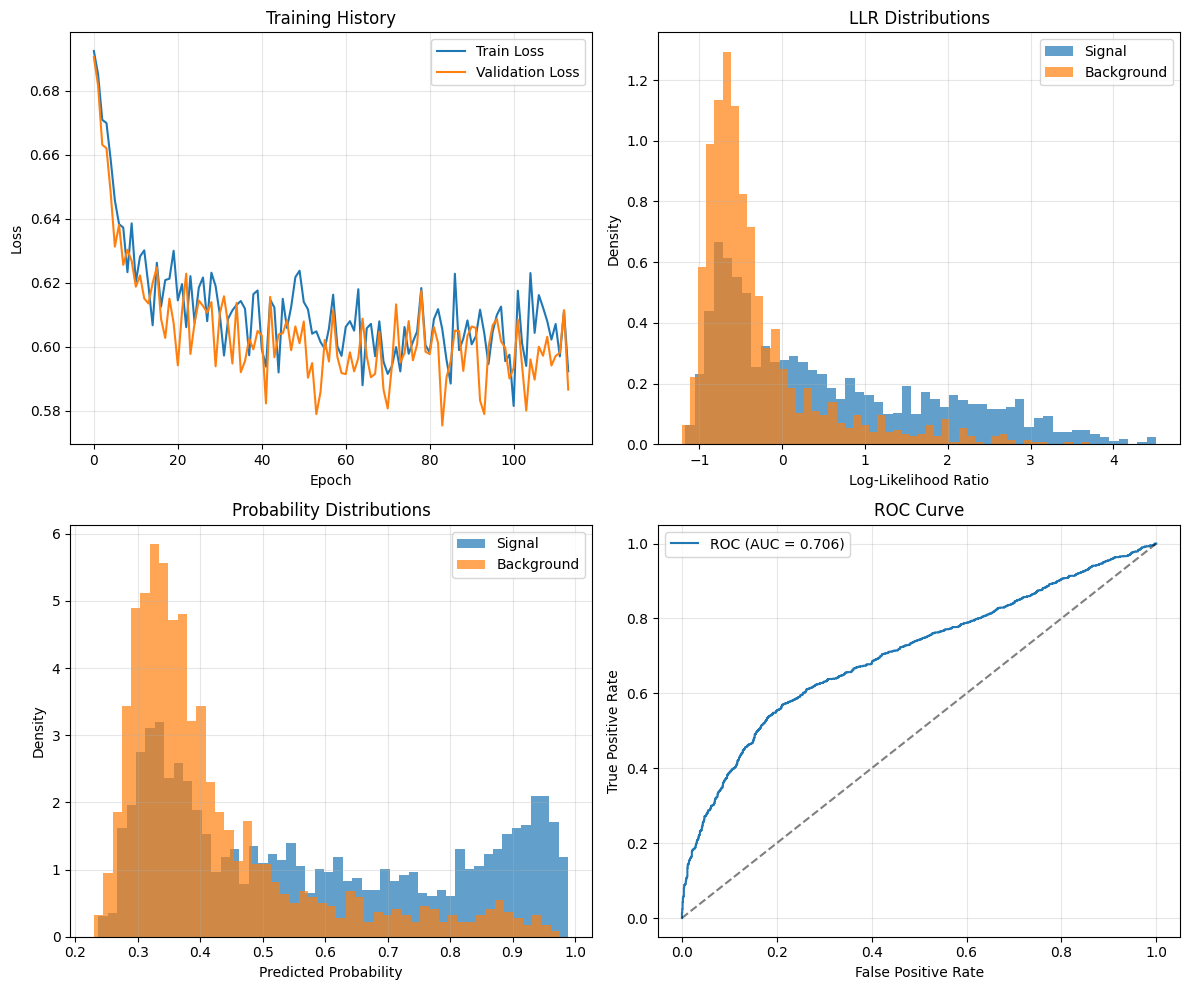

In [12]:
print(f"Training completed! Final validation loss: {history['val_loss'][-1]:.4f}")

# Test the trained network
# test_points = torch.randn(200, 3, device=geometry.device)

# Generate test data using the same surrogate functions
test_loader = llr_net.generate_batch_data_from_events(
    # None,
    # test_points,
    signal_surrogate_func=light_yield_surrogate,
    background_surrogate_func=light_yield_surrogate,
    signal_event_params=test_signal_event_params,
    background_event_params=test_background_event_params,
    batch_size=64,
    signal_ratio=0.5,
    add_noise=True,
    sig_noise_scale=0.05,  # 5% noise on signal light yields
    bkg_noise_scale=0.2,  # 10% noise on background light yields
    samples_per_epoch=3000,
    keep_opt_point=True,  # Keep optimization point in features
    sr_mode=False,  # Use symbolic regression mode
    output_denoised=True
    # random_seed=123
)

# Evaluate the model
predictions = []
true_labels = []
llr_values = []
all_features = []
denoised_values = []
# llr_net.shared_mlp.eval()
with torch.no_grad():
    for features, labels, denoised in test_loader:
        # Get LLR predictions
        batch_llr = llr_net.predict_log_likelihood_ratio(features)
        batch_probs = llr_net.predict_proba(features)
        # print(len(batch_llr), len(batch_probs), len(labels))
        
        llr_values.extend(batch_llr.cpu().numpy())
        predictions.extend(batch_probs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_features.extend(features.cpu().numpy())  # Store features for further analysis
        denoised_values.extend(denoised.cpu().numpy())

# Convert to numpy arrays
llr_values = np.array(llr_values)
predictions = np.array(predictions)
true_labels = np.array(true_labels)
all_features = np.array(all_features).squeeze()  # Remove batch dimension if needed
denoised_values = np.array(denoised_values)
print(len(llr_values), len(predictions), len(true_labels))

# Evaluate performance
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

binary_preds = (predictions > 0.5).astype(int)
accuracy = accuracy_score(true_labels, binary_preds)
auc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, binary_preds)
recall = recall_score(true_labels, binary_preds)

print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training history
axes[0,0].plot(history['train_loss'], label='Train Loss')
axes[0,0].plot(history['val_loss'], label='Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('Training History')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# LLR distributions
signal_mask = true_labels == 1
background_mask = true_labels == 0

axes[0,1].hist(llr_values[signal_mask], bins=50, alpha=0.7, label='Signal', density=True)
axes[0,1].hist(llr_values[background_mask], bins=50, alpha=0.7, label='Background', density=True)
axes[0,1].set_xlabel('Log-Likelihood Ratio')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('LLR Distributions')
# axes[0,1].set_xlim(-5, 5)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Probability distributions
axes[1,0].hist(predictions[signal_mask], bins=50, alpha=0.7, label='Signal', density=True)
axes[1,0].hist(predictions[background_mask], bins=50, alpha=0.7, label='Background', density=True)
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Probability Distributions')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
axes[1,1].plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curve')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

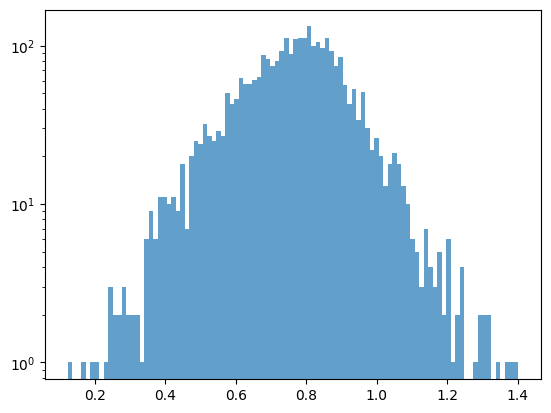

In [13]:
# plt.figure(figsize=(10, 6))
plt.hist(all_features[:,-1], bins=100, alpha=0.7, label='Light Yield Feature')
plt.yscale('log')

/var/folders/40/hq_tym9s6_vcj1qtwjlrl3lw0000gn/T/ipykernel_89165/1002549673.py:12: RuntimeWarning: divide by zero encountered in divide
  llr_density = np.log(binned_sig/binned_bg)
/var/folders/40/hq_tym9s6_vcj1qtwjlrl3lw0000gn/T/ipykernel_89165/1002549673.py:12: RuntimeWarning: invalid value encountered in divide
  llr_density = np.log(binned_sig/binned_bg)


(-1.6528511047363281, 4.1584131717681885)

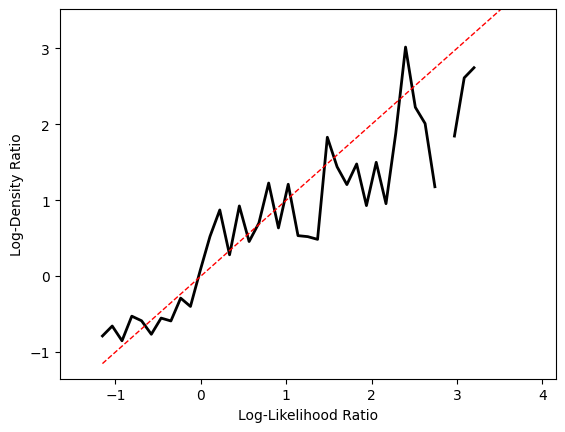

In [14]:
bg_mask = true_labels == 0
sig_mask = true_labels == 1
binned_bg, bins = np.histogram(llr_values[bg_mask], bins=50, range=(min(llr_values), max(llr_values)), density=True)
binned_sig, bins= np.histogram(llr_values[sig_mask], bins=50, range=(min(llr_values), max(llr_values)), density=True)
f_vals = (bins[:-1] + bins[1:]) / 2  # Midpoints of bins
# print(f"bin centers: {f_vals}")
# kde_b = gaussian_kde(nn_log_ratios[bg_mask])
# kde_s = gaussian_kde(nn_log_ratios[sig_mask])

# f_vals = np.linspace(-7, 7, 1000)
# llr_density = np.log(kde_s(f_vals) / kde_b(f_vals))
llr_density = np.log(binned_sig/binned_bg)  
# print(f'llr density: {llr_density}')
plt.plot(f_vals, llr_density, 'k-', linewidth=2, label='LLR Density')
plt.plot(f_vals, f_vals, 'r--', linewidth=1)
plt.xlabel('Log-Likelihood Ratio')
plt.ylabel('Log-Density Ratio')
plt.ylim(min(llr_density[~np.isinf(np.abs(llr_density)) & ~np.isnan(llr_density)])-0.5, max(llr_density[~np.isinf(np.abs(llr_density)) & ~np.isnan(llr_density)])+0.5)
plt.xlim(min(f_vals[~np.isinf(np.abs(llr_density)) & ~np.isnan(llr_density)])-0.5, max(f_vals[~np.isinf(np.abs(llr_density)) & ~np.isnan(llr_density)])+0.5)
# plt.xlim(-4.5,4)
# plt.ylim(-4.5,4)

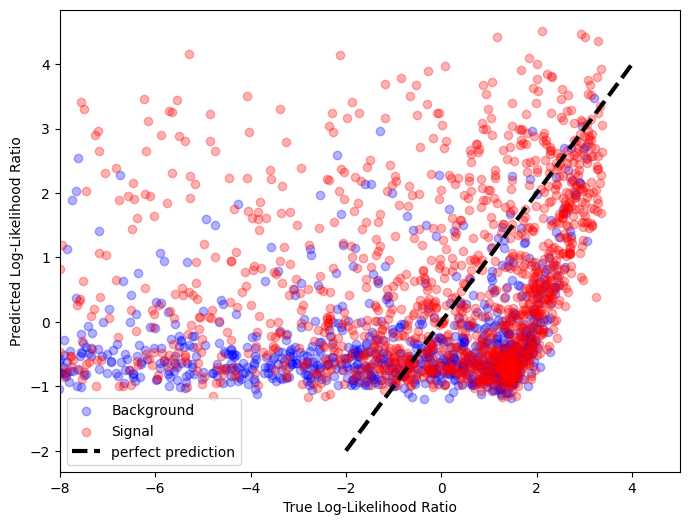

In [15]:
# plot true llr vs predicted llr
plt.figure(figsize=(8, 6))
signal_x_bias = 0
background_x_bias = 0
signal_noise_scale = 0.05
background_noise_scale = 0.2
zenith_bias = 6  # Bias towards horizon for background events
true_llr = np.zeros_like(llr_values)
true_llr += np.log(all_features[:, -2])  # energy log likelihood ratio (3.7 - 2.7)
true_llr += np.log((2+zenith_bias) / (1 + zenith_bias * (1 - np.abs(np.cos(all_features[:, -4]))))) # zenith log likelihood ratio for background bias towards horizon
mean_bg_denoised = np.mean(denoised_values[true_labels == 0])
mean_sig_denoised = np.mean(denoised_values[true_labels == 1])
lyields = all_features[:, -1]
true_llr += np.log(background_noise_scale / signal_noise_scale)  # noise scale log likelihood ratio
true_llr += 0.5* (np.log(lyields) - np.log(mean_bg_denoised))**2 / background_noise_scale**2  # light yield log likelihood ratio
true_llr -= 0.5* (np.log(lyields) - np.log(mean_sig_denoised))**2 / signal_noise_scale**2  # light yield log likelihood ratio
true_llr += (signal_x_bias - background_x_bias) * (all_features[:, 0] + all_features[:, 3]) + (background_x_bias**2 - signal_x_bias**2) / 2  # x bias log likelihood ratio
# scatter background and signal points
plt.scatter(true_llr[true_labels == 0], llr_values[true_labels == 0], alpha=0.3, label='Background', color='blue')
plt.scatter(true_llr[true_labels == 1], llr_values[true_labels == 1], alpha=0.3, label='Signal', color='red')
# plot binned means of background and signal
# plt.hist2d(true_llr[true_labels == 1], llr_values[true_labels == 1], bins=50, cmap='Reds', alpha=0.5, label='Signal')
# plt.hist2d(true_llr[true_labels == 0], llr_values[true_labels == 0], bins=50, cmap='Blues', alpha=0.5, label='Background')

plt.plot([-2, 4], [-2, 4], 'k--', linewidth=3, label='perfect prediction')
plt.xlabel('True Log-Likelihood Ratio')
plt.ylabel('Predicted Log-Likelihood Ratio')
plt.xlim(-8, 5)
# plt.ylim(-8, 5)
plt.legend()
plt.show()


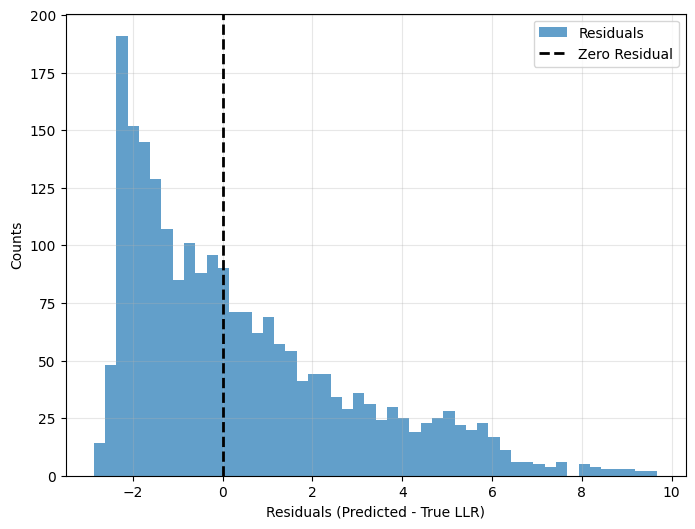

In [16]:
# plot histogram of residuals of predicted vs true llr
plt.figure(figsize=(8, 6))
residuals = llr_values[true_llr > -7] - true_llr[true_llr > -7]
plt.hist(residuals, bins=50, alpha=0.7, label='Residuals', density=False)
plt.axvline(0, color='k', linestyle='--', linewidth=2, label='Zero Residual')
plt.xlabel('Residuals (Predicted - True LLR)')
plt.ylabel('Counts')
# plt.xlim(-5, 5)
# plt.title('Histogram of Residuals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# # Test with many events and random optimization points over fixed energy values
# n_signal_events = 50  # More events per test
# n_background_events = 50
# n_optimization_points = 20  # Number of random optimization points to test
# n_energy_values = 10  # Number of energy values to test (0.8 to 1.0)
# n_trials = 20  # Number of trials to average over

# full_dom = geometry.domain_size
# half_dom = full_dom / 2

# # Create fixed energy values from 0.8 to 1.0
# energy_values = torch.linspace(0.8, 1.0, n_energy_values, device=geometry.device)
# print(f"Testing energy values: {energy_values.cpu().numpy()}")

# # Generate random optimization points
# optimization_points = torch.randn(n_optimization_points, 3, device=geometry.device) * geometry.domain_size - geometry.domain_size / 2
# print(f"Testing {n_optimization_points} random optimization points")

# # Storage for results
# all_results = np.zeros((n_energy_values, n_optimization_points, n_trials, 2))  # [energy, opt_point, trial, signal/background]

# for energy_idx, energy_val in enumerate(energy_values):
#     print(f"Testing energy {energy_val:.2f} ({energy_idx+1}/{n_energy_values})")
    
#     for trial in range(n_trials):
#         # Generate event parameters with fixed energy
#         signal_event_params = {
#             # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([full_dom, full_dom, full_dom]) - torch.tensor([half_dom, half_dom, half_dom]),  
#             'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom/2, full_dom, full_dom]) - torch.tensor([-half_dom/2, half_dom, half_dom]),  # Focused on right side
#             'zenith': torch.rand(n_signal_events, device=geometry.device) * np.pi,
#             'azimuth': torch.rand(n_signal_events, device=geometry.device) * 2 * np.pi,
#             'energy': torch.full((n_signal_events,), energy_val, device=geometry.device)  # Fixed energy
#         }
        
#         background_event_params = {
#             # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([full_dom, full_dom, full_dom]) - torch.tensor([half_dom, half_dom, half_dom]),
#             'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([-half_dom/2, full_dom, full_dom]) - torch.tensor([half_dom/2, half_dom, half_dom]),  # Focused on left side
#             'zenith': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_background_zenith(n_samples=n_background_events),
#             'azimuth': torch.rand(n_background_events, device=geometry.device) * 2 * np.pi,
#             'energy': torch.full((n_background_events,), energy_val, device=geometry.device)  # Fixed energy
#         }
        
#         # Test each optimization point
#         for opt_idx, opt_point in enumerate(optimization_points):
#             # Generate mixed batch data for this optimization point
#             mixed_test_loader = llr_net.generate_batch_data_from_events(
#                 optimization_points=[opt_point.cpu().numpy()],
#                 signal_surrogate_func=light_yield_surrogate,
#                 background_surrogate_func=light_yield_surrogate,
#                 signal_event_params=signal_event_params,
#                 background_event_params=background_event_params,
#                 batch_size=100,  # Larger batch size
#                 signal_ratio=0.5,  # Mixed batches like training
#                 add_noise=True,
#                 sig_noise_scale=0.05,
#                 bkg_noise_scale=0.2,
#                 samples_per_epoch=100,
#                 keep_opt_point=True
#             )
            
#             # Evaluate LLR values
#             llr_values = []
#             signal_labels = []
            
#             with torch.no_grad():
#                 for features, labels in mixed_test_loader:
#                     batch_llr = llr_net.predict_log_likelihood_ratio(features)
#                     llr_values.extend(batch_llr.cpu().numpy())
#                     signal_labels.extend(labels.cpu().numpy())
            
#             llr_values = np.array(llr_values)
#             signal_labels = np.array(signal_labels)
            
#             # Separate signal and background LLR values
#             signal_llr = llr_values[signal_labels == 1]
#             background_llr = llr_values[signal_labels == 0]
            
#             # Store results (mean LLR for signal and background)
#             all_results[energy_idx, opt_idx, trial, 0] = np.mean(signal_llr) if len(signal_llr) > 0 else 0
#             all_results[energy_idx, opt_idx, trial, 1] = np.mean(background_llr) if len(background_llr) > 0 else 0

# # Calculate statistics across trials
# mean_results = np.mean(all_results, axis=2)  # Average over trials
# std_results = np.std(all_results, axis=2)    # Standard deviation over trials

# # Plot results
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# # Plot 1: LLR vs Energy (averaged over all optimization points)
# energy_signal_mean = np.mean(mean_results[:, :, 0], axis=1)
# energy_signal_std = np.mean(std_results[:, :, 0], axis=1)
# energy_background_mean = np.mean(mean_results[:, :, 1], axis=1)
# energy_background_std = np.mean(std_results[:, :, 1], axis=1)

# axes[0,0].errorbar(energy_values.cpu().numpy(), energy_signal_mean, yerr=energy_signal_std, 
#                    label='Signal LLR', color='blue', marker='o', capsize=5)
# axes[0,0].errorbar(energy_values.cpu().numpy(), energy_background_mean, yerr=energy_background_std, 
#                    label='Background LLR', color='red', marker='s', capsize=5)
# axes[0,0].set_xlabel('Energy')
# axes[0,0].set_ylabel('Mean LLR')
# axes[0,0].set_title('LLR vs Energy (averaged over optimization points)')
# axes[0,0].legend()
# axes[0,0].grid(True, alpha=0.3)

# # Plot 2: LLR difference (Signal - Background) vs Energy
# llr_difference = energy_signal_mean - energy_background_mean
# llr_diff_error = np.sqrt(energy_signal_std**2 + energy_background_std**2)

# axes[0,1].errorbar(energy_values.cpu().numpy(), llr_difference, yerr=llr_diff_error, 
#                    color='green', marker='o', capsize=5)
# axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
# axes[0,1].set_xlabel('Energy')
# axes[0,1].set_ylabel('LLR Difference (Signal - Background)')
# axes[0,1].set_title('Signal-Background LLR Difference vs Energy')
# axes[0,1].grid(True, alpha=0.3)

# # Plot 3: Distribution of LLR values for different energies
# for i, energy_val in enumerate(energy_values[::2]):  # Plot every other energy for clarity
#     signal_data = all_results[i*2, :, :, 0].flatten()
#     background_data = all_results[i*2, :, :, 1].flatten()
    
#     axes[1,0].hist(signal_data, bins=20, alpha=0.6, density=True, 
#                    label=f'Signal E={energy_val:.2f}', histtype='step', linewidth=2)
#     axes[1,0].hist(background_data, bins=20, alpha=0.6, density=True, 
#                    label=f'Background E={energy_val:.2f}', histtype='step', linewidth=2, linestyle='--')

# axes[1,0].set_xlabel('LLR')
# axes[1,0].set_ylabel('Density')
# axes[1,0].set_title('LLR Distributions for Different Energies')
# axes[1,0].legend()
# axes[1,0].grid(True, alpha=0.3)

# # Plot 4: Spatial distribution of optimization points colored by LLR difference
# # Use middle energy value for this plot
# mid_energy_idx = n_energy_values // 2
# opt_points_np = optimization_points.cpu().numpy()
# llr_diff_spatial = mean_results[mid_energy_idx, :, 0] - mean_results[mid_energy_idx, :, 1]

# scatter = axes[1,1].scatter(opt_points_np[:, 0], opt_points_np[:, 1], 
#                            c=llr_diff_spatial, cmap='RdBu_r', s=60, alpha=0.8)
# axes[1,1].set_xlabel('X coordinate')
# axes[1,1].set_ylabel('Y coordinate')
# axes[1,1].set_title(f'Spatial LLR Difference (Energy={energy_values[mid_energy_idx]:.2f})')
# plt.colorbar(scatter, ax=axes[1,1], label='LLR Difference')
# axes[1,1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Print summary statistics
# print(f"\nSummary Statistics:")
# print(f"Energy range: {energy_values[0]:.2f} to {energy_values[-1]:.2f}")
# print(f"Number of optimization points: {n_optimization_points}")
# print(f"Number of trials per configuration: {n_trials}")
# print(f"Events per trial: {n_signal_events} signal + {n_background_events} background")

# print(f"\nOverall LLR Statistics:")
# all_signal_llr = all_results[:, :, :, 0].flatten()
# all_background_llr = all_results[:, :, :, 1].flatten()
# print(f"Signal LLR: mean={np.mean(all_signal_llr):.4f}, std={np.std(all_signal_llr):.4f}")
# print(f"Background LLR: mean={np.mean(all_background_llr):.4f}, std={np.std(all_background_llr):.4f}")
# print(f"Overall LLR difference: {np.mean(all_signal_llr) - np.mean(all_background_llr):.4f}")

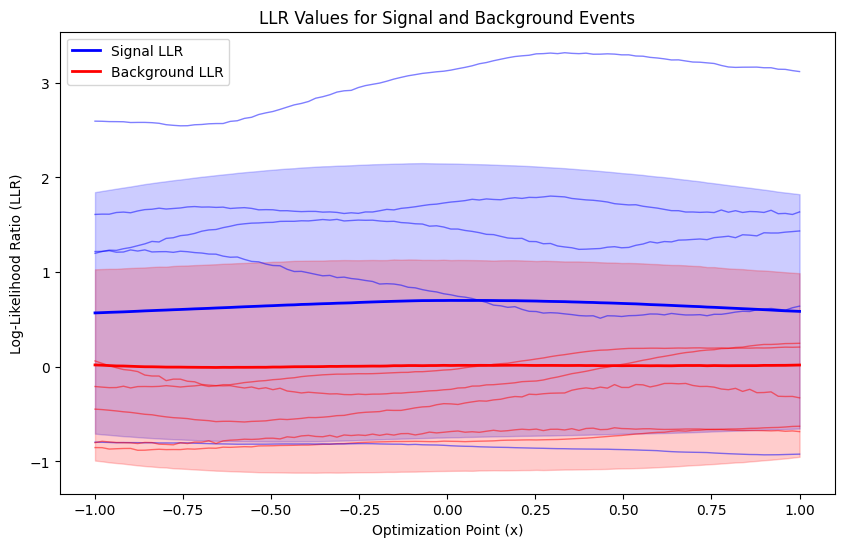

In [17]:
n_signal_events = 1
n_background_events = 1
full_dom = geometry.domain_size
half_dom = full_dom / 2
all_events_signal = np.zeros((100, 100))
all_events_background = np.zeros((100, 100))
plt.figure(figsize=(10, 6))

for i in range(100):
    new_test_signal_event_params = {
        'position': torch.randn(n_signal_events, 3, device=geometry.device), #+ torch.tensor([half_dom, 0, 0]),  # Centered around +x
        # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom, full_dom, full_dom]) - torch.tensor([0, half_dom, half_dom]),  # Focused on right side
        # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([full_dom, full_dom, full_dom]) - torch.tensor([half_dom, half_dom, half_dom]),
        'zenith': torch.rand(n_signal_events, device=geometry.device) * np.pi,  # 0 to π
        'azimuth': torch.rand(n_signal_events, device=geometry.device) * 2 * np.pi,  # 0 to 2π
        'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_signal_events, gamma=2.7)
    }
    # make a new dictionary with the signal event parameters appearing twice
    new_test_signal_event_params = copy.deepcopy(new_test_signal_event_params)
    new_test_signal_event_params['position'] = torch.cat([new_test_signal_event_params['position'], new_test_signal_event_params['position']], dim=0)
    new_test_signal_event_params['zenith'] = torch.cat([new_test_signal_event_params['zenith'], new_test_signal_event_params['zenith']], dim=0)
    new_test_signal_event_params['azimuth'] = torch.cat([new_test_signal_event_params['azimuth'], new_test_signal_event_params['azimuth']], dim=0)
    new_test_signal_event_params['energy'] = torch.cat([new_test_signal_event_params['energy'], new_test_signal_event_params['energy']], dim=0) 

    new_test_background_event_params = {
        'position': torch.randn(n_background_events, 3, device=geometry.device), #+ torch.tensor([-half_dom, 0, 0]),  # Centered around -x
        # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([-half_dom, full_dom, full_dom]) - torch.tensor([0, half_dom, half_dom]),  # Focused on left side
        # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([full_dom, full_dom, full_dom]) - torch.tensor([half_dom, half_dom, half_dom]),
        'zenith': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_background_zenith(n_samples=n_background_events),
        'azimuth': torch.rand(n_background_events, device=geometry.device) * 2 * np.pi,
        'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_background_events, gamma=3.7)}

    new_test_background_event_params = copy.deepcopy(new_test_background_event_params)
    new_test_background_event_params['position'] = torch.cat([new_test_background_event_params['position'], new_test_background_event_params['position']], dim=0)
    new_test_background_event_params['zenith'] = torch.cat([new_test_background_event_params['zenith'], new_test_background_event_params['zenith']], dim=0)
    new_test_background_event_params['azimuth'] = torch.cat([new_test_background_event_params['azimuth'], new_test_background_event_params['azimuth']], dim=0)
    new_test_background_event_params['energy'] = torch.cat([new_test_background_event_params['energy'], new_test_background_event_params['energy']], dim=0)

    all_signal_llr_values = []
    all_bkg_llr_values = []
    all_signal_llr_sigma = []
    all_bkg_llr_sigma = []
    for x in torch.linspace(-1,1, 100):
        
        # Generate test data using the same surrogate functions
        signal_test_loader = llr_net.generate_batch_data_from_events(
            # None,
            optimization_points=[[x, 0, 0]],
            signal_surrogate_func=light_yield_surrogate,
            background_surrogate_func=light_yield_surrogate,
            signal_event_params=new_test_signal_event_params,
            background_event_params=new_test_background_event_params,
            batch_size=2,
            signal_ratio=1,
            add_noise=True,
            sig_noise_scale=0.05,  # 5% noise on signal light yields
            bkg_noise_scale=0.10,  # 10% noise on background light yields
            samples_per_epoch=10,
            keep_opt_point=True,  # Keep optimization point in features
            # random_seed=123
        )
        
        bkg_test_loader = llr_net.generate_batch_data_from_events(
            # None,
            optimization_points=[[x, 0, 0]],
            signal_surrogate_func=light_yield_surrogate,
            background_surrogate_func=light_yield_surrogate,
            signal_event_params=new_test_signal_event_params,
            background_event_params=new_test_background_event_params,
            batch_size=2,
            signal_ratio=0,
            add_noise=True,
            sig_noise_scale=0.05,  # 5% noise on signal light yields
            bkg_noise_scale=0.10,  # 10% noise on background light yields
            samples_per_epoch=10,
            keep_opt_point=True,  # Keep optimization point in features
            # random_seed=123
        )

        # Evaluate the model
        # predictions = []
        # true_labels = []
        # llr_values = []
        # all_features = []
        signal_llr_values = []
        bkg_llr_values = []
        # llr_net.shared_mlp.eval()
        with torch.no_grad():
            for features, labels in signal_test_loader:
                # Get LLR predictions
                batch_llr = llr_net.predict_log_likelihood_ratio(features)
                signal_llr_values.extend(batch_llr.cpu().numpy())
            for features, labels in bkg_test_loader:
                # Get LLR predictions
                batch_llr = llr_net.predict_log_likelihood_ratio(features)
                bkg_llr_values.extend(batch_llr.cpu().numpy())
        all_signal_llr_values.append(np.mean(signal_llr_values))
        all_bkg_llr_values.append(np.mean(bkg_llr_values))
        all_signal_llr_sigma.append(np.std(signal_llr_values))
        all_bkg_llr_sigma.append(np.std(bkg_llr_values))
    all_events_signal[:, i] = all_signal_llr_values
    all_events_background[:, i] = all_bkg_llr_values
    if i % 20 == 0:
        plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_signal_llr_values, color='blue', linewidth=1, alpha=0.5)
        # plt.fill_between(torch.linspace(-1, 1, 100).cpu().numpy(), 
        #                 np.array(all_signal_llr_values) - np.array(all_signal_llr_sigma), 
                        #  np.array(all_signal_llr_values) + np.array(all_signal_llr_sigma), 
                        #  color='blue', alpha=0.2)
        plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_bkg_llr_values, color='red', linewidth=1, alpha=0.5)
        # plt.fill_between(torch.linspace(-1, 1, 100).cpu().numpy(), 
        #                 np.array(all_bkg_llr_values) - np.array(all_bkg_llr_sigma), 
        #                 np.array(all_bkg_llr_values) + np.array(all_bkg_llr_sigma), 
        #                 color='red', alpha=0.2)
all_signal_llr_sigma = np.std(all_events_signal, axis=1)
all_bkg_llr_sigma = np.std(all_events_background, axis=1)   
all_signal_llr_values = np.mean(all_events_signal, axis=1)
all_bkg_llr_values = np.mean(all_events_background, axis=1)
# Plot the results

plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_signal_llr_values, label='Signal LLR', color='blue', linewidth=2)
plt.fill_between(torch.linspace(-1, 1, 100).cpu().numpy(), 
                 np.array(all_signal_llr_values) - np.array(all_signal_llr_sigma), 
                 np.array(all_signal_llr_values) + np.array(all_signal_llr_sigma), 
                 color='blue', alpha=0.2)
plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_bkg_llr_values, label='Background LLR', color='red', linewidth=2)
plt.fill_between(torch.linspace(-1, 1, 100).cpu().numpy(), 
                 np.array(all_bkg_llr_values) - np.array(all_bkg_llr_sigma), 
                 np.array(all_bkg_llr_values) + np.array(all_bkg_llr_sigma), 
                 color='red', alpha=0.2)
# plt.yscale('log')
plt.xlabel('Optimization Point (x)')
plt.ylabel('Log-Likelihood Ratio (LLR)')
plt.title('LLR Values for Signal and Background Events')
plt.legend()
plt.show()


/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/utils/surrogates.py:619: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(sigma_front, device=self.device),
/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/utils/surrogates.py:620: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(sigma_back, device=self.device)


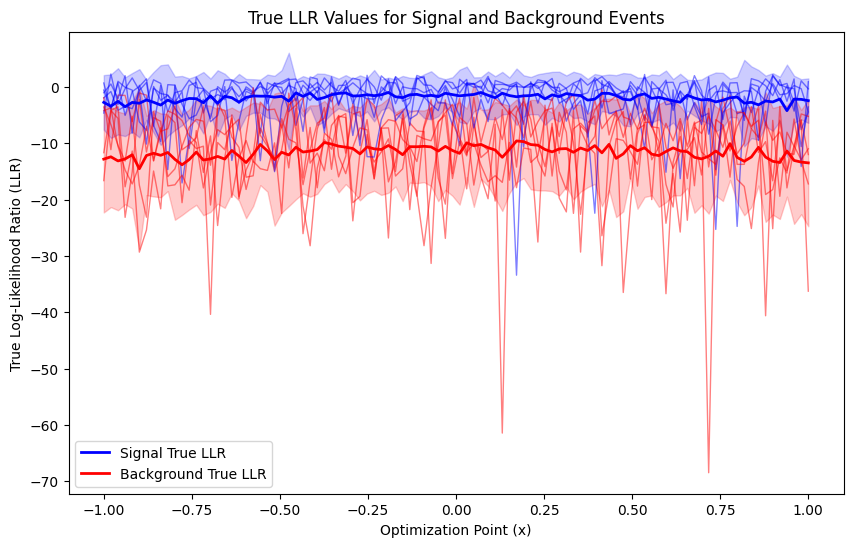

In [20]:
n_signal_events = 1000
n_background_events = 1000
full_dom = geometry.domain_size
half_dom = full_dom / 2
all_events_signal = np.zeros((100, 100))
all_events_background = np.zeros((100, 100))
all_events_signal_yields = np.zeros((100, 100))
all_events_background_yields = np.zeros((100, 100))
signal_x_bias = 0
background_x_bias = 0
signal_noise_scale = 0.05
background_noise_scale = 0.2
zenith_bias = 6  # Bias towards horizon for background events
plt.figure(figsize=(10, 6))

for i in range(100):
    new_test_signal_event_params = {
        'position': torch.randn(n_signal_events, 3, device=geometry.device),
        # 'position': torch.randn(n_signal_events, 3, device=geometry.device) + torch.tensor([half_dom/2, 0, 0]),  # Centered around +x
        # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom, full_dom, full_dom]) - torch.tensor([0, half_dom, half_dom]),  # Focused on right side
        # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([full_dom, full_dom, full_dom]) - torch.tensor([half_dom, half_dom, half_dom]),
        'zenith': torch.rand(n_signal_events, device=geometry.device) * np.pi,  # 0 to π
        'azimuth': torch.rand(n_signal_events, device=geometry.device) * 2 * np.pi,  # 0 to 2π
        'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_signal_events, gamma=2.7)
    }
    # make a new dictionary with the signal event parameters appearing twice
    # new_test_signal_event_params = copy.deepcopy(new_test_signal_event_params)
    # new_test_signal_event_params['position'] = torch.cat([new_test_signal_event_params['position'], new_test_signal_event_params['position']], dim=0)
    # new_test_signal_event_params['zenith'] = torch.cat([new_test_signal_event_params['zenith'], new_test_signal_event_params['zenith']], dim=0)
    # new_test_signal_event_params['azimuth'] = torch.cat([new_test_signal_event_params['azimuth'], new_test_signal_event_params['azimuth']], dim=0)
    # new_test_signal_event_params['energy'] = torch.cat([new_test_signal_event_params['energy'], new_test_signal_event_params['energy']], dim=0) 

    new_test_background_event_params = {
        'position': torch.randn(n_background_events, 3, device=geometry.device),
        # 'position': torch.randn(n_background_events, 3, device=geometry.device) + torch.tensor([-half_dom/2, 0, 0]),  # Centered around -x
        # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([-half_dom, full_dom, full_dom]) - torch.tensor([0, half_dom, half_dom]),  # Focused on left side
        # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([full_dom, full_dom, full_dom]) - torch.tensor([half_dom, half_dom, half_dom]),
        'zenith': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_background_zenith(n_samples=n_background_events, a=6),
        # 'zenith': torch.rand(n_background_events, device=geometry.device) * np.pi,
        'azimuth': torch.rand(n_background_events, device=geometry.device) * 2 * np.pi,
        'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_background_events, gamma=3.7)}

    # new_test_background_event_params = copy.deepcopy(new_test_background_event_params)
    # new_test_background_event_params['position'] = torch.cat([new_test_background_event_params['position'], new_test_background_event_params['position']], dim=0)
    # new_test_background_event_params['zenith'] = torch.cat([new_test_background_event_params['zenith'], new_test_background_event_params['zenith']], dim=0)
    # new_test_background_event_params['azimuth'] = torch.cat([new_test_background_event_params['azimuth'], new_test_background_event_params['azimuth']], dim=0)
    # new_test_background_event_params['energy'] = torch.cat([new_test_background_event_params['energy'], new_test_background_event_params['energy']], dim=0)

    all_signal_llr_values = []
    all_bkg_llr_values = []
    all_signal_llr_sigma = []
    all_bkg_llr_sigma = []
    all_signal_yields = []
    all_bkg_yields = []
    for x in torch.linspace(-1,1, 100):
        
        # Generate test data using the same surrogate functions
        test_loader = llr_net.generate_batch_data_from_events(
            # None,
            optimization_points=[[x, 0, 0]],
            signal_surrogate_func=light_yield_surrogate,
            background_surrogate_func=light_yield_surrogate,
            signal_event_params=new_test_signal_event_params,
            background_event_params=new_test_background_event_params,
            batch_size=20,
            signal_ratio=0.5,
            add_noise=True,
            sig_noise_scale=0.05,  # 5% noise on signal light yields
            bkg_noise_scale=0.20,  # 10% noise on background light yields
            samples_per_epoch=20,
            keep_opt_point=True,  # Keep optimization point in features
            output_denoised=True,  # Output denoised light yields
            # random_seed=123
        )
        
        # bkg_test_loader = llr_net.generate_batch_data_from_events(
        #     # None,
        #     optimization_points=[[x, 0, 0]],
        #     signal_surrogate_func=light_yield_surrogate,
        #     background_surrogate_func=light_yield_surrogate,
        #     signal_event_params=new_test_signal_event_params,
        #     background_event_params=new_test_background_event_params,
        #     batch_size=10,
        #     signal_ratio=0,
        #     add_noise=True,
        #     sig_noise_scale=0.05,  # 5% noise on signal light yields
        #     bkg_noise_scale=0.05,  # 5% noise on background light yields
        #     samples_per_epoch=10,
        #     keep_opt_point=True,  # Keep optimization point in features
        #     output_denoised=True,  # Output denoised light yields
        #     # random_seed=123
        # )

        # Calculate true LLR from the sampled events (similar to cell 13)
        signal_llr_values = []
        bkg_llr_values = []
        signal_yields = []
        bkg_yields = []
       
        
        with torch.no_grad():
            for features, labels, denoised in test_loader:
                # Calculate true LLR for each sample
                true_llr = np.zeros(features.shape[0])
                all_features = features.cpu().numpy()
                
                # Get denoised values (light yield without noise)
                denoised_values = denoised.cpu().numpy()
                mean_bg_denoised = np.mean(denoised_values[labels.cpu().numpy() == 0])
                mean_sig_denoised = np.mean(denoised_values[labels.cpu().numpy() == 1])
                
                # Energy log likelihood ratio (2.7 - 3.7)
                true_llr += np.log(all_features[:, -2])
                
                # Zenith log likelihood ratio for background bias towards horizon
                true_llr += np.log((2 + zenith_bias) / (1 + zenith_bias * (1 - np.abs(np.cos(all_features[:, -4])))))

                # Light yield noise ratio
                true_llr += np.log(background_noise_scale / signal_noise_scale)
                
                # Light yield log likelihood ratio with different noise scales
                lyields = all_features[:, -1]
                true_llr += 0.5 * (np.log(lyields) - np.log(mean_bg_denoised))**2 / background_noise_scale**2  # background noise
                true_llr -= 0.5 * (np.log(lyields) - np.log(mean_sig_denoised))**2 / signal_noise_scale**2  # signal noise

                # Position bias log likelihood ratio
                true_llr += (signal_x_bias - background_x_bias) * (all_features[:, 0] + all_features[:, 3]) + (background_x_bias**2 - signal_x_bias**2) / 2

                signal_llr_values.extend(true_llr[labels.cpu().numpy() == 1])
                signal_yields.extend(lyields)

                bkg_llr_values.extend(true_llr[labels.cpu().numpy() == 0])
                bkg_yields.extend(lyields[labels.cpu().numpy() == 0])

            # for features, labels, denoised in bkg_test_loader:
            #     # Calculate true LLR for each sample
            #     true_llr = np.zeros(features.shape[0])
            #     all_features = features.cpu().numpy()
                
            #     # Get denoised values (light yield without noise)
            #     denoised_values = denoised.cpu().numpy()
            #     mean_bg_denoised = np.mean(denoised_values[labels.cpu().numpy() == 0])
            #     mean_sig_denoised = np.mean(denoised_values[labels.cpu().numpy() == 1])
                
            #     # Energy log likelihood ratio (2.7 - 3.7)
            #     true_llr += np.log(all_features[:, -2])
                
            #     # Zenith log likelihood ratio for background bias towards horizon
            #     true_llr += np.log(1 / (1 + 1.5 * (1 - np.abs(np.cos(all_features[:, -4])))))
                
            #     # Light yield noise ratio
            #     true_llr += np.log(background_noise_scale / signal_noise_scale)
                
            #     # Light yield log likelihood ratio with different noise scales
            #     lyields = all_features[:, -1]
            #     true_llr += 0.5 * (np.log(lyields) - np.log(mean_bg_denoised))**2 / background_noise_scale**2  # background noise
            #     true_llr -= 0.5 * (np.log(lyields) - np.log(mean_sig_denoised))**2 / signal_noise_scale**2  # signal noise

            #     # Position bias log likelihood ratio
            #     true_llr += (signal_x_bias - background_x_bias) * (all_features[:, 0] + all_features[:, 3]) + (background_x_bias**2 - signal_x_bias**2) / 2

                
                
        all_signal_llr_values.append(np.mean(signal_llr_values))
        all_bkg_llr_values.append(np.mean(bkg_llr_values))
        all_signal_llr_sigma.append(np.std(signal_llr_values))
        all_bkg_llr_sigma.append(np.std(bkg_llr_values))
        all_signal_yields.append(np.mean(signal_yields))
        all_bkg_yields.append(np.mean(bkg_yields))
    all_events_signal[:, i] = all_signal_llr_values
    all_events_background[:, i] = all_bkg_llr_values
    all_events_signal_yields[:, i] = all_signal_yields
    all_events_background_yields[:, i] = all_bkg_yields
    if i % 20 == 0:
        plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_signal_llr_values, color='blue', linewidth=1, alpha=0.5)
        plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_bkg_llr_values, color='red', linewidth=1, alpha=0.5)

all_signal_llr_sigma = np.std(all_events_signal, axis=1)
all_bkg_llr_sigma = np.std(all_events_background, axis=1)   
all_signal_llr_values = np.mean(all_events_signal, axis=1)
all_bkg_llr_values = np.mean(all_events_background, axis=1)

# Plot the results with true LLR calculations
plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_signal_llr_values, label='Signal True LLR', color='blue', linewidth=2)
plt.fill_between(torch.linspace(-1, 1, 100).cpu().numpy(), 
                 np.array(all_signal_llr_values) - np.array(all_signal_llr_sigma), 
                 np.array(all_signal_llr_values) + np.array(all_signal_llr_sigma), 
                 color='blue', alpha=0.2)
plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_bkg_llr_values, label='Background True LLR', color='red', linewidth=2)
plt.fill_between(torch.linspace(-1, 1, 100).cpu().numpy(), 
                 np.array(all_bkg_llr_values) - np.array(all_bkg_llr_sigma), 
                 np.array(all_bkg_llr_values) + np.array(all_bkg_llr_sigma), 
                 color='red', alpha=0.2)
# plt.ylim(-15,3)
plt.xlabel('Optimization Point (x)')
plt.ylabel('True Log-Likelihood Ratio (LLR)')
plt.title('True LLR Values for Signal and Background Events')
plt.legend()
plt.show()

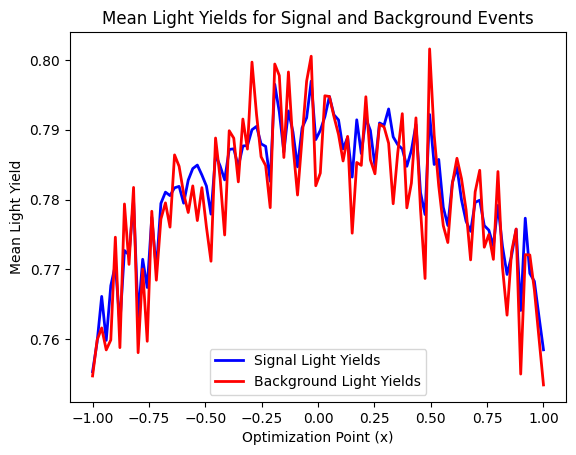

In [21]:
plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_events_signal_yields.mean(axis=1), label='Signal Light Yields', color='blue', linewidth=2)
plt.plot(torch.linspace(-1, 1, 100).cpu().numpy(), all_events_background_yields.mean(axis=1), label='Background Light Yields', color='red', linewidth=2)
plt.xlabel('Optimization Point (x)')
plt.ylabel('Mean Light Yield')
plt.title('Mean Light Yields for Signal and Background Events')
plt.legend()
plt.show()

In [18]:
# Create dramatically different test parameters
debug_signal_params = {
    'position': torch.tensor([[1.0, 0, 0]], device=geometry.device),  # Far right
    'energy': torch.tensor([0.8], device=geometry.device),           # High energy
    'zenith': torch.tensor([np.pi], device=geometry.device),
    'azimuth': torch.tensor([np.pi], device=geometry.device)
}

debug_background_params = {
    'position': torch.tensor([[-1.0, 0, 0]], device=geometry.device), # Far left
    'energy': torch.tensor([0.8], device=geometry.device),           # Low energy  
    'zenith': torch.tensor([0], device=geometry.device),
    'azimuth': torch.tensor([0], device=geometry.device)
}

# Test signal_ratio=1 (should use signal params only)
signal_loader = llr_net.generate_batch_data_from_events(
    optimization_points=[[1, 0, 0]],
    signal_surrogate_func=light_yield_surrogate,
    background_surrogate_func=light_yield_surrogate,
    signal_event_params=debug_signal_params,
    background_event_params=debug_background_params,
    signal_ratio=1,  # Should use ONLY signal params
    samples_per_epoch=1,
    add_noise=False
)

# Test signal_ratio=0 (should use background params only)  
background_loader = llr_net.generate_batch_data_from_events(
    optimization_points=[[1, 0, 0]],
    signal_surrogate_func=light_yield_surrogate,
    background_surrogate_func=light_yield_surrogate,
    signal_event_params=debug_signal_params,
    background_event_params=debug_background_params,
    signal_ratio=0,  # Should use ONLY background params
    samples_per_epoch=1,
    add_noise=False
)

# Check if light yields are different
for features, labels in signal_loader:
    signal_yield = features[0, -1].item()
    print(f"Signal ratio=1 light yield: {signal_yield}")

for features, labels in background_loader:
    background_yield = features[0, -1].item()
    print(f"Signal ratio=0 light yield: {background_yield}")

print(f"Light yield difference: {signal_yield - background_yield}")

Signal ratio=1 light yield: 0.800000011920929
Signal ratio=0 light yield: 0.7384930849075317
Light yield difference: 0.06150692701339722


In [19]:
# # Predict expected LLR at new positions

# test_positions = torch.randn(500, 3, device=geometry.device) * geometry.domain_size - geometry.domain_size / 2

# n_signal_events = 20
# n_background_events = 20
# test_signal_event_params = {
#     'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom/2, full_dom, full_dom]) - torch.tensor([-half_dom/2, half_dom, half_dom]),  # Focused on right side
#     'zenith': torch.rand(n_signal_events, device=geometry.device) * np.pi,  # 0 to π
#     'azimuth': torch.rand(n_signal_events, device=geometry.device) * 2 * np.pi,  # 0 to 2π
#     'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_signal_events, gamma=2.7)
# }

# test_background_event_params = {
#     'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([-half_dom/2, full_dom, full_dom]) - torch.tensor([half_dom/2, half_dom, half_dom]),  # Focused on left side
#     'zenith': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_background_zenith(n_samples=n_background_events),
#     'azimuth': torch.rand(n_background_events, device=geometry.device) * 2 * np.pi,
#     'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_background_events, gamma=3.7)
# }
# #combine test_signal_event_params and test_background_event_params
# test_event_params = {
#     'position': torch.cat((test_signal_event_params['position'], test_background_event_params['position']), dim=0),
#     'zenith': torch.cat((test_signal_event_params['zenith'], test_background_event_params['zenith']), dim=0),
#     'azimuth': torch.cat((test_signal_event_params['azimuth'], test_background_event_params['azimuth']), dim=0),
#     'energy': torch.cat((test_signal_event_params['energy'], test_background_event_params['energy']), dim=0)
# }


# results, pred_expected_llr, true_expected_llr = kl_model.evaluate(
#     test_positions, test_event_params,
#     light_yield_surrogate,
#     light_yield_surrogate,
#     )

In [20]:
# kl_model.plot_training_history()

# # Create binned predicted vs true expected LLR plot
# bins = np.linspace(-5, 5, 50)
# plt.figure(figsize=(12, 10))

# # Convert tensors to numpy if needed
# if isinstance(pred_expected_llr, torch.Tensor):
#     pred_expected_llr_np = pred_expected_llr.cpu().numpy()
# else:
#     pred_expected_llr_np = pred_expected_llr

# if isinstance(true_expected_llr, torch.Tensor):
#     true_expected_llr_np = true_expected_llr.cpu().numpy()
# else:
#     true_expected_llr_np = true_expected_llr

# # Create 2x2 subplot layout
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # 1. 2D histogram (binned plot)
# # h, xedges, yedges, im = axes[0,0].hist2d(true_expected_llr_np, pred_expected_llr_np, 
# #                                          bins=30, density=True, cmap='viridis')
# # axes[0,0].plot([-5, 5], [-5, 5], 'r--', alpha=0.8, linewidth=2, label='Perfect Prediction')
# # axes[0,0].set_xlabel('True Expected LLR')
# # axes[0,0].set_ylabel('Predicted Expected LLR')
# # axes[0,0].set_title('2D Histogram: Predicted vs True Expected LLR')
# # axes[0,0].legend()
# # axes[0,0].grid(True, alpha=0.3)
# # plt.colorbar(im, ax=axes[0,0], label='Density')

# # 2. Binned mean and std
# bin_centers = (bins[:-1] + bins[1:]) / 2
# digitized = np.digitize(true_expected_llr_np, bins)

# bin_means = []
# bin_stds = []
# bin_counts = []

# for i in range(1, len(bins)):
#     mask = digitized == i
#     if np.sum(mask) > 0:
#         bin_means.append(np.mean(pred_expected_llr_np[mask]))
#         bin_stds.append(np.std(pred_expected_llr_np[mask]))
#         bin_counts.append(np.sum(mask))
#     else:
#         bin_means.append(np.nan)
#         bin_stds.append(np.nan)
#         bin_counts.append(0)

# bin_means = np.array(bin_means)
# bin_stds = np.array(bin_stds)
# bin_counts = np.array(bin_counts)

# # Plot binned means with error bars
# valid_mask = ~np.isnan(bin_means) & (bin_counts > 5)  # Only plot bins with >5 samples
# axes[0].errorbar(bin_centers[valid_mask], bin_means[valid_mask], 
#                    yerr=bin_stds[valid_mask], fmt='o', capsize=5, 
#                    alpha=0.7, label='Binned Mean ± Std')
# plot_lims = [min(min(bin_centers[valid_mask]),min(bin_means[valid_mask])), max(max(bin_centers[valid_mask]), max(bin_means[valid_mask]))]
# axes[0].plot(plot_lims, plot_lims, 'r--', alpha=0.8, linewidth=2, label='Perfect Prediction')
# axes[0].set_xlabel('True Expected LLR')
# axes[0].set_ylabel('Predicted Expected LLR')
# axes[0].set_title('Binned Mean Predicted vs True Expected LLR')
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # 3. Residuals plot
# residuals = pred_expected_llr_np - true_expected_llr_np
# # axes[1,0].scatter(true_expected_llr_np, residuals, alpha=0.6, s=20)
# # axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
# # axes[1,0].set_xlabel('True Expected LLR')
# # axes[1,0].set_ylabel('Residuals (Predicted - True)')
# # axes[1,0].set_title('Residuals vs True Expected LLR')
# # axes[1,0].grid(True, alpha=0.3)

# # # Add mean and std of residuals as text
# mean_residual = np.mean(residuals)
# std_residual = np.std(residuals)
# # axes[1,0].text(0.05, 0.95, f'Mean: {mean_residual:.4f}\nStd: {std_residual:.4f}', 
# #                transform=axes[1,0].transAxes, verticalalignment='top',
# #                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# # 4. Distribution of residuals
# axes[1].hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# axes[1].axvline(x=0, color='r', linestyle='--', alpha=0.8, label='Zero Residual')
# axes[1].axvline(x=mean_residual, color='orange', linestyle='-', alpha=0.8, label=f'Mean: {mean_residual:.4f}')
# axes[1].set_xlabel('Residuals (Predicted - True)')
# axes[1].set_ylabel('Density')
# axes[1].set_title('Distribution of Residuals')
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Print summary statistics
# print(f"\nKLnet Evaluation Summary:")
# print(f"{'='*40}")
# print(f"Number of test samples: {len(pred_expected_llr_np)}")
# print(f"Mean Squared Error: {results.get('mse', 'N/A'):.6f}")
# # print(f"Mean Absolute Error: {results.get('mae', 'N/A'):.6f}")
# # print(f"R² Score: {results.get('r2', 'N/A'):.6f}")
# print(f"Mean Residual: {mean_residual:.6f}")
# print(f"Std Residual: {std_residual:.6f}")
# print(f"RMSE: {np.sqrt(np.mean(residuals**2)):.6f}")

# # Correlation coefficient
# correlation = np.corrcoef(true_expected_llr_np, pred_expected_llr_np)[0, 1]
# print(f"Correlation coefficient: {correlation:.6f}")

# # Range statistics
# print(f"\nRange Statistics:")
# print(f"True Expected LLR range: [{np.min(true_expected_llr_np):.3f}, {np.max(true_expected_llr_np):.3f}]")
# print(f"Predicted Expected LLR range: [{np.min(pred_expected_llr_np):.3f}, {np.max(pred_expected_llr_np):.3f}]")

# #plot distribution of true expected LLR and predicted expected LLR
# plt.figure(figsize=(6, 4))
# plt.hist(true_expected_llr_np, bins=50, alpha=0.7, label='True Expected LLR', density=True, color='blue', edgecolor='black')
# plt.hist(pred_expected_llr_np, bins=50, alpha=0.7, label='Predicted Expected LLR', density=True, color='orange', edgecolor='black')
# plt.xlabel('Expected LLR')
# plt.ylabel('Density')
# plt.title('Distribution of True vs Predicted Expected LLR')
# plt.legend()

In [18]:
n_signal_events = 10000
n_background_events = 10000
opt_signal_event_params = {
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([half_dom/2, full_dom, full_dom]) - torch.tensor([-half_dom/2, half_dom, half_dom]),  # Focused on right side
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([full_dom, full_dom, full_dom]) - torch.tensor([half_dom, half_dom, half_dom]), 
    'position': torch.randn(n_signal_events, 3, device=geometry.device), # Centered around +x
    'zenith': torch.rand(n_signal_events, device=geometry.device) * np.pi,  # 0 to π
    'azimuth': torch.rand(n_signal_events, device=geometry.device) * 2 * np.pi,  # 0 to 2π
    'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_signal_events, gamma=2.7)
}

opt_background_event_params = {
    # 'position': torch.randn(n_signal_events, 3, device=geometry.device) * torch.tensor([-half_dom/2, full_dom, full_dom]) - torch.tensor([half_dom/2, half_dom, half_dom]),  # Focused on left side
        # 'position': torch.randn(n_background_events, 3, device=geometry.device) * torch.tensor([full_dom, full_dom, full_dom]) - torch.tensor([half_dom, half_dom, half_dom]),
    'position': torch.randn(n_background_events, 3, device=geometry.device),  # Centered around -x
    'zenith': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_background_zenith(n_samples=n_background_events, a=6),
    'azimuth': torch.rand(n_background_events, device=geometry.device) * 2 * np.pi,
    'energy': nugget.utils.surrogates.Surrogate(device=geometry.device).sample_power_law(n_samples=n_background_events, gamma=3.7)
}

In [19]:
geometry = nugget.utils.geometries.EvanescentString(
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        dim=3,
        domain_size=2.0,
        n_strings=500,
        points_per_string=10,
        optimize_z=False,
        starting_weight=4,   
)

In [93]:
importlib.reload(nugget.utils.losses)
importlib.reload(nugget.utils.vis_tools)
importlib.reload(nugget.utils.surrogates)
conflict_free = False
llr_loss_function = nugget.utils.losses.WeightedLLRLoss(
        device=geometry.device,
        domain_size=geometry.domain_size,
        repulsion_weight=0,
        boundary_weight=0,
        string_repulsion_weight=0.1,
        max_local_rad=0.08,
        path_repulsion_weight=0,
        z_repulsion_weight=0,
        llr_weight=0.1,
        eva_weight=0.01,
        eva_boundary_weight=0,
        eva_binary_weight=0.01,
        eva_string_num_weight=0.05,
        eva_min_num_strings=70,
        min_dist=0.001,
        conflict_free=conflict_free,
        print_loss=False,
        signal_event_params=opt_signal_event_params,
        background_event_params=opt_background_event_params,
        batch_size_per_point=20,
        num_samples=20,
        use_klnet=False,
        # klnet_model=kl_model,
        signal_ratio=0.5,
        
        keep_opt_point=True,  # Keep optimization point in features
        add_noise=True,
        sig_noise_scale=0.05,  # 5% noise on signal light yields
        bkg_noise_scale=0.2,  # 20% noise on background light yields
        llr_net= llr_net,
        background_surrogate_func=light_yield_surrogate,
        signal_surrogate_func=light_yield_surrogate,
        use_bce_loss=False,  # Use BCE loss for LLR
        boost_signal=True,
        signal_boost_weight=0.5,
        boost_signal_yield=True,
        signal_yield_boost_weight=0.5,
        compute_fisher_info=True,
        fisher_info_weight=1
        
        
        
)
llr_visualizer = nugget.utils.vis_tools.Visualizer(
                                device=geometry.device,
                                dim=geometry.dim, 
                                domain_size=geometry.domain_size,
                                gif_temp_dir='gif_temp'
        )

In [80]:
geom_dict = geometry.initialize_points()
loss_history = []
snr_history = []
optimizers = {}
schedulers = {}
# num_iterations = 400


string_xy = geom_dict.get('string_xy')
string_weights = geom_dict.get('string_weights')

# print(f"Optimizing string_xy with shape {string_xy.shape}")
# string_xy.requires_grad_(True)
# geom_dict['string_xy'] = string_xy
# xy_optimizer = torch.optim.Adam([string_xy], lr=self.xy_learning_rate)
# optimizers['string_xy'] = xy_optimizer

# xy_scheduler = nugget.utils.schedulers.create_scheduler(
#     xy_optimizer, num_iterations,
#     'exp', {'gamma': 0.95}
# )

# schedulers['string_xy'] = xy_scheduler

print(f"Optimizing llr_string_weights with shape {string_weights.shape}")
string_weights.requires_grad_(True)
geom_dict['string_weights'] = string_weights
weights_optimizer = torch.optim.Adam([string_weights], lr=0.1)
optimizers['string_weights'] = weights_optimizer

# weights_scheduler = nugget.utils.schedulers.create_scheduler(
#     weights_optimizer, num_iterations,
#     'exp', {'gamma': 0.95}
# )

# schedulers['string_weights'] = weights_scheduler

Optimizing llr_string_weights with shape torch.Size([500])


In [18]:
# get geometry strings in xy minimum distance to each other
dists = np.linalg.norm(string_xy[:, None, :] - string_xy[None, :, :], axis=-1)
print(min(dists[dists > 0]))  # Minimum distance between strings

0.07692229


In [22]:
precomputations = llr_loss_function.compute_llr_per_string(
    string_xy=geom_dict['string_xy'],
    n_strings=geometry.n_strings,  
    points_3d=geom_dict['points'],  
    compute_snr=False,
    compute_signal_yield=True,
    signal_surrogate_func=light_yield_surrogate,
    background_surrogate_func=light_yield_surrogate,
    compute_true_llr=True,
    signal_x_bias= 0,
    background_x_bias= 0,
    zenith_bias=6
)
precomputed_llr_per_string, precomputed_signal_llr, precomputed_background_llr, precomputed_snr_per_string, precomputed_true_llr, precomputed_true_signal_llr, precomputed_true_background_llr, precomputed_signal_yield_per_string, precomputed_fisher_info_per_string = precomputations
precomputed_true_background_llr[torch.isnan(precomputed_true_background_llr)] = 0
precomputed_true_signal_llr[torch.isnan(precomputed_true_signal_llr)] = 0

Computing LLR for 500 strings with 20 samples per point


/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/utils/surrogates.py:2422: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opt_point = torch.tensor(self.opt_points[opt_idx], device=self.device, dtype=torch.float32)


In [78]:
print(torch.mean(precomputed_llr_per_string))
# print(torch.mean(precomputed_snr_per_string))
print(torch.mean(precomputed_signal_llr))
print(torch.mean(precomputed_background_llr)) 
print(torch.mean(precomputed_true_llr))  
print(torch.mean(precomputed_true_signal_llr))
print(torch.mean(precomputed_true_background_llr))
print(torch.mean(precomputed_signal_yield_per_string))
print(torch.mean(precomputed_fisher_info_per_string, axis=0))

tensor(8.8670)
tensor(36.3378)
tensor(-18.5677)
tensor(-424.2794)
tensor(-154.5074)
tensor(-690.1045)
tensor(7.6827)
tensor([[ 5.6095e-01, -4.8675e-05, -1.5599e-02],
        [-4.8675e-05,  4.7645e-03, -6.7197e-05],
        [-1.5599e-02, -6.7197e-05,  1.3757e-02]])


In [75]:
llr_visualizer.cleanup_gif_temp_files()

Cleaned up temporary directory: gif_temp
GIF temporary files cleanup completed.


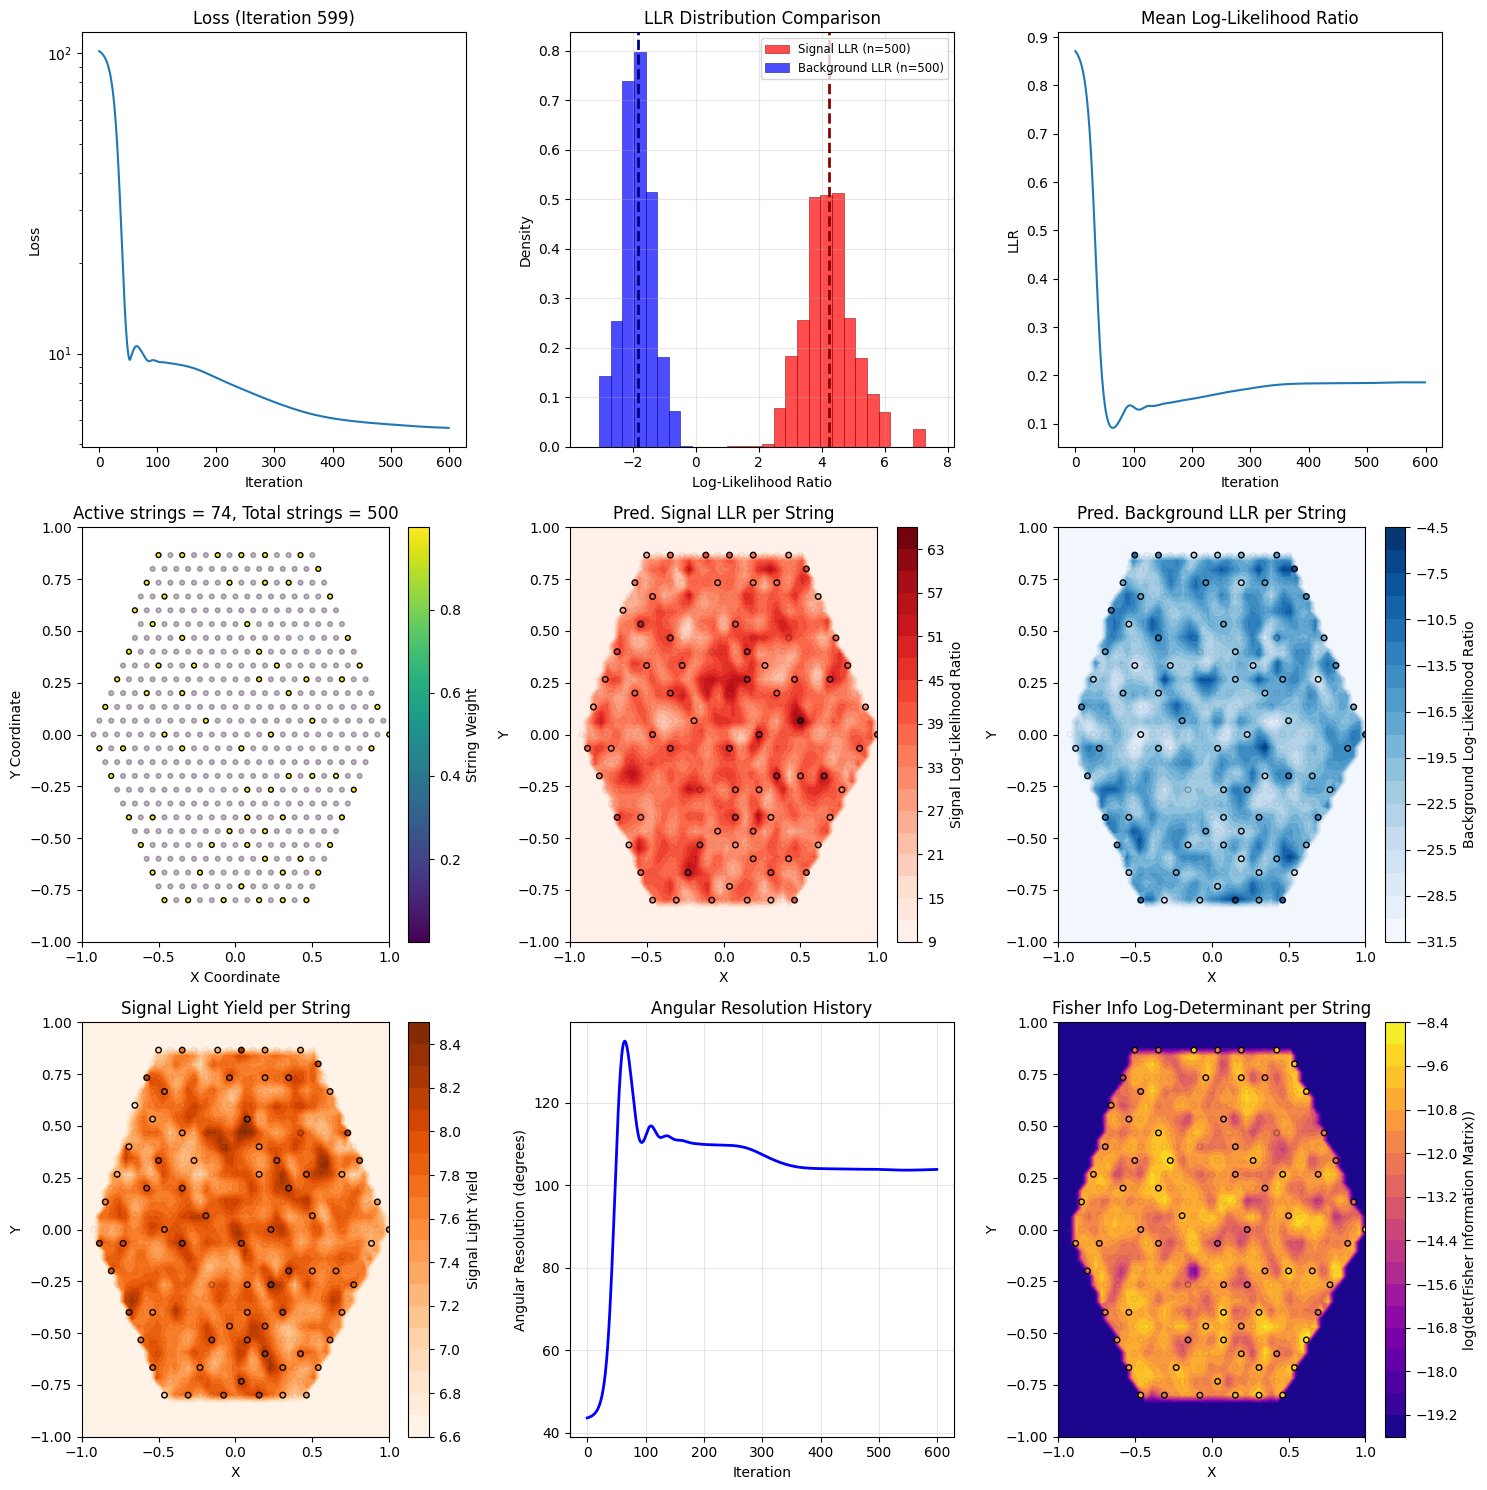

In [81]:
visualize_every = 10
plot_types=["loss", "llr_histogram",  "llr_history", "string_weights_scatter", "signal_llr_contour", "background_llr_contour","signal_light_yield_contour", "angular_resolution", "fisher_info_logdet"]
gif_vis_every = 5
make_gif=False
gif_plot_selection=plot_types
gif_fps=10
gif_filename='llr_notebook_evanescent_optimization_9.gif'
num_iterations = 600

# Initialize resolution history lists
angular_resolution_history = []
energy_resolution_history = []

print(f"Starting optimization with {num_iterations} iterations...")
for iteration in range(num_iterations):
    for optimizer in optimizers.values():
        optimizer.zero_grad()
    loss, avg_snr, llr_per_string, weighted_fisher_info_value = llr_loss_function(
        points_3d=geom_dict['points'],
        string_xy=geom_dict['string_xy'],
        string_weights=geom_dict['string_weights'],
        num_strings=geometry.n_strings,
        points_per_string=geom_dict['points_per_string_list'],
        # compute_snr=True,
        # signal_surrogate_func=light_yield_surrogate,
        # background_surrogate_func=light_yield_surrogate,
        precomputed_signal_yield_per_string=precomputed_signal_yield_per_string,
        precomputed_llr_per_string=precomputed_llr_per_string,
        precomputed_background_llr= precomputed_background_llr,
        precomputed_signal_llr= precomputed_signal_llr,
        precomputed_fisher_info_per_string=precomputed_fisher_info_per_string,
        # precomputed_signal_probs_per_string= precomputed_signal_pred_per_string,
        # precomputed_background_probs_per_string=precomputed_background_pred_per_string,
                       
                    )
    
    # Calculate weighted total angular and energy resolution

        # Get string weights (normalized probabilities)
    current_string_weights = torch.sigmoid(geom_dict.get('string_weights', None))
    
    
    # Fisher information parameters: ['energy', 'azimuth', 'zenith']
    fisher_info_params = ['energy', 'azimuth', 'zenith']
    energy_idx = 0  # energy is first parameter
    azimuth_idx = 1  # azimuth is second parameter  
    zenith_idx = 2   # zenith is third parameter
    
    # Calculate resolution per string
    string_angular_resolutions = []
    string_energy_resolutions = []


    fisher_matrix = torch.sum(precomputed_fisher_info_per_string * current_string_weights.unsqueeze(1).unsqueeze(2), dim=0)

    # Add small regularization for numerical stability
    reg_matrix = torch.eye(fisher_matrix.shape[0]) * 1e-6
    regularized_fisher = fisher_matrix + reg_matrix
    
    # Compute inverse Fisher matrix (covariance matrix)
    cov_matrix = torch.inverse(regularized_fisher)
    
    # Angular resolution: sqrt(var_azimuth + var_zenith)
    var_azimuth = cov_matrix[azimuth_idx, azimuth_idx]
    var_zenith = cov_matrix[zenith_idx, zenith_idx]
    angular_resolution_rad = torch.sqrt(var_azimuth + var_zenith)
    angular_resolution_deg = angular_resolution_rad * 180.0 / torch.pi
    
    # Energy resolution: sqrt(var_energy)
    var_energy = cov_matrix[energy_idx, energy_idx]
    energy_resolution = torch.sqrt(var_energy)

    # Add to history
    angular_resolution_history.append(angular_resolution_deg.detach().cpu().numpy())
    energy_resolution_history.append(energy_resolution.detach().cpu().numpy())

    if conflict_free:
        # Handle multiple loss components with ConFIG
        grads = []
        total_loss = 0
        
        # Clear gradients first
        for optimizer in optimizers.values():
            optimizer.zero_grad()
        
        # Compute gradients for each loss component separately
        for loss_fn in loss:
            total_loss += loss_fn.item()
            
            # Compute gradients for this loss component
            loss_fn.backward(retain_graph=True)
            
            # Extract gradients manually for string_weights
            if string_weights.grad is not None:
                grad_vector = string_weights.grad.view(-1).clone()
                grads.append(grad_vector)
            
            # Clear gradients for next loss component
            string_weights.grad = None

        # Calculate conflict-free gradient direction
        if len(grads) > 0:
            g_config = ConFIG_update(grads)
            
            # Apply conflict-free gradients to string_weights manually
            string_weights.grad = g_config.view_as(string_weights)

        # Update parameters
        for optimizer in optimizers.values():
            optimizer.step()
            
        loss_history.append(total_loss)
    else:
        loss.backward(retain_graph=True)
        for optimizer in optimizers.values():
            optimizer.step()
        loss_history.append(loss.item())
    snr_history.append(avg_snr)
    # indices = np.random.permutation(len(all_signal_funcs))[:min(len(all_signal_funcs), 200)]
    # vis_signal_funcs = [all_signal_funcs[i] for i in indices]  # Keep a few for visualization
    # # vis_signal_funcs = all_signal_funcs
    
    # for scheduler in schedulers.values():
    #     scheduler.step()
    geom_dict = geometry.update_points(**geom_dict)
    vis_kwargs = {
        # 'llr_xyz_data': vis_xyz,
        # 'llr_values': vis_llr,
        # 'snr_xyz_data': vis_xyz,
        # 'snr_values': vis_snr,
        'fisher_info_per_string': precomputed_fisher_info_per_string,
        'signal_light_yield_per_string': precomputed_signal_yield_per_string,
        'true_signal_llr_per_string': precomputed_true_signal_llr,
        'true_background_llr_per_string': precomputed_true_background_llr,
        'snr_per_string': precomputed_snr_per_string,
        'background_llr_per_string': precomputed_background_llr,
        'signal_llr_per_string': precomputed_signal_llr,
        'all_snr': None,
        'no_background': False,
        'background_scale': 10,
        'points_per_string': torch.tensor(geom_dict.get('points_per_string_list', 1), dtype=torch.float32),
        # 'snr_per_string': snr_per_string,
        'string_weights': torch.sigmoid(geom_dict.get('string_weights', None)).detach().cpu().numpy(),
        'num_strings': geometry.n_strings,
        'llr_history': snr_history,
        }
    additional_metrics = {
                'string_indices': geom_dict.get('string_indices'),
                'llr_history': snr_history,
                'angular_resolution_history': angular_resolution_history,
                'energy_resolution_history': energy_resolution_history
                    }
    if visualize_every > 0 and (iteration % visualize_every == 0 or iteration == num_iterations - 1):                                                                                                                                                       
        llr_visualizer.visualize_progress(
        iteration=iteration,
        points_3d=geom_dict.get('points'),
        loss_history=loss_history,
        additional_metrics=additional_metrics,
        string_indices=geom_dict.get('string_indices'),
        points_per_string_list=geom_dict.get('points_per_string_list'),
        string_xy=geom_dict.get('string_xy'),
        slice_res=50,
        multi_slice=True,
        loss_type='weighted_snr',
        string_logits=geom_dict.get('string_logits'),
        plot_types=plot_types,
        **vis_kwargs
                )

    if make_gif and (iteration % gif_vis_every == 0 or iteration == num_iterations - 1):
        llr_visualizer.visualize_progress(
            iteration=iteration,
            points_3d=geom_dict.get('points'),
            loss_history=loss_history,
            additional_metrics=additional_metrics,
            string_indices=geom_dict.get('string_indices'),
            points_per_string_list=geom_dict.get('points_per_string_list'),
            string_xy=geom_dict.get('string_xy'),
            slice_res=50,
            multi_slice=True,
            loss_type='weighted_snr',
            string_logits=geom_dict.get('string_logits'),
            plot_types=plot_types,
            make_gif=True,
            save_individual_images=True,
            compile_gif_on_iteration=False,
            # gif_filename=gif_filename,
            # gif_fps=gif_fps,
            gif_plot_selection=gif_plot_selection,
            **vis_kwargs
        )

In [77]:
llr_visualizer.finalize_gif(
    gif_filename=gif_filename,
    gif_fps=gif_fps,
    cleanup_images=False)

Successfully compiled GIF 'llr_notebook_evanescent_optimization_9.gif' with 121 frames.


True

In [82]:
base_geometry = nugget.utils.geometries.EvanescentString(
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        dim=3,
        domain_size=2.0,
        n_strings=74,
        points_per_string=10,
        optimize_z=False,
        starting_weight=4,   
)
base_geom_dict = base_geometry.initialize_points()

In [83]:
base_precomputations = llr_loss_function.compute_llr_per_string(
    string_xy=base_geom_dict['string_xy'],
    n_strings=base_geometry.n_strings,  
    points_3d=base_geom_dict['points'],  
    compute_snr=False,
    compute_signal_yield=True,
    signal_surrogate_func=light_yield_surrogate,
    background_surrogate_func=light_yield_surrogate,
    compute_true_llr=True,
    signal_x_bias= 0,
    background_x_bias= 0,
    zenith_bias=6
)
base_llr_per_string, base_signal_llr, base_background_llr, base_snr_per_string, base_true_llr, base_true_signal_llr, base_true_background_llr, base_signal_yield_per_string, base_fisher_info_per_string = base_precomputations

Computing LLR for 74 strings with 20 samples per point


/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/utils/surrogates.py:2422: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opt_point = torch.tensor(self.opt_points[opt_idx], device=self.device, dtype=torch.float32)


In [84]:
base_fisher_matrix = torch.sum(base_fisher_info_per_string, dim=0)

# Add small regularization for numerical stability
base_reg_matrix = torch.eye(base_fisher_matrix.shape[0]) * 1e-6
base_regularized_fisher = base_fisher_matrix + base_reg_matrix

# Compute inverse Fisher matrix (covariance matrix)
base_cov_matrix = torch.inverse(base_regularized_fisher)

# Angular resolution: sqrt(var_azimuth + var_zenith)
base_var_azimuth = base_cov_matrix[azimuth_idx, azimuth_idx]
base_var_zenith = base_cov_matrix[zenith_idx, zenith_idx]
base_angular_resolution_rad = torch.sqrt(base_var_azimuth + base_var_zenith)
base_angular_resolution_deg = base_angular_resolution_rad * 180.0 / torch.pi

# Energy resolution: sqrt(var_energy)
base_var_energy = base_cov_matrix[energy_idx, energy_idx]
base_energy_resolution = torch.sqrt(base_var_energy)

In [85]:
print(base_angular_resolution_deg, angular_resolution_history[-1])
print(base_energy_resolution, energy_resolution_history[-1])

tensor(110.8358) 103.872406
tensor(0.1579) 0.1535143


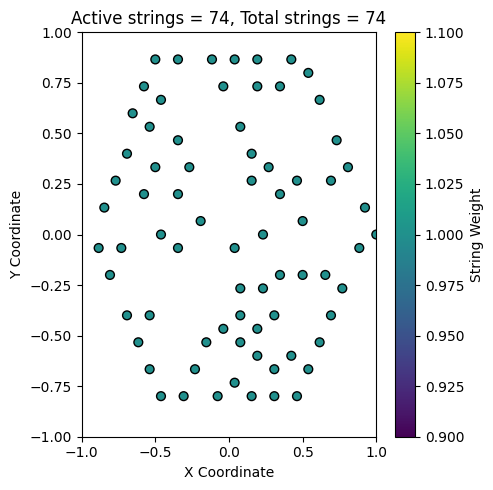

In [101]:
active_strings = torch.sigmoid(geom_dict.get('string_weights', None)).detach().cpu().numpy() > 0.7
vis_kwargs = {
        'points_per_string': torch.tensor(geom_dict.get('points_per_string_list', 1), dtype=torch.float32),
        'string_weights': np.ones(len(geom_dict.get('string_xy')[active_strings])),
        'num_strings': len(geom_dict.get('string_xy')[active_strings]),
        }
additional_metrics = {
            'string_indices': geom_dict.get('string_indices')[active_strings],
                }
                                                                                                                                                    
llr_visualizer.visualize_progress(
iteration=0,
loss_history=None,
points_3d=geom_dict.get('points'),
additional_metrics=additional_metrics,
string_indices=geom_dict.get('string_indices')[active_strings],
# points_per_string_list=geom_dict.get('points_per_string_list')[active_strings],
string_xy=geom_dict.get('string_xy')[active_strings],
slice_res=50,
multi_slice=True,
loss_type='weighted_snr',
plot_types=['string_weights_scatter'],
**vis_kwargs
        )


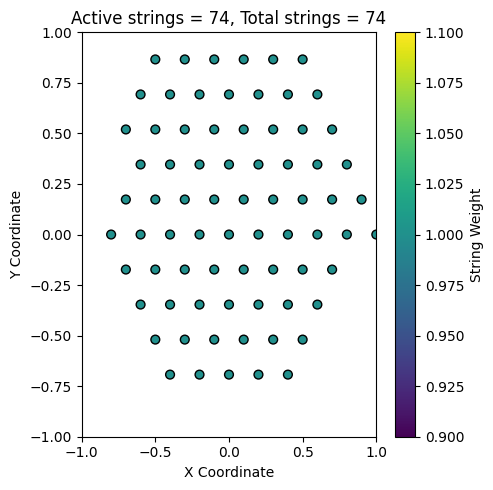

In [102]:
vis_kwargs = {
        'points_per_string': torch.tensor(base_geom_dict.get('points_per_string_list', 1), dtype=torch.float32),
        'string_weights': np.ones(base_geometry.n_strings),
        'num_strings': base_geometry.n_strings,
        }
additional_metrics = {
            'string_indices': base_geom_dict.get('string_indices'),
                }
                                                                                                                                                    
llr_visualizer.visualize_progress(
iteration=0,
loss_history=None,
points_3d=base_geom_dict.get('points'),
additional_metrics=additional_metrics,
string_indices=base_geom_dict.get('string_indices'),
points_per_string_list=base_geom_dict.get('points_per_string_list'),
string_xy=base_geom_dict.get('string_xy'),
slice_res=50,
multi_slice=True,
loss_type='weighted_snr',
string_logits=base_geom_dict.get('string_logits'),
plot_types=['string_weights_scatter'],
**vis_kwargs
        )

In [104]:
torch.sigmoid(geom_dict.get('string_weights', None)).detach().cpu().numpy()[active_strings]

array([0.994242  , 0.9944766 , 0.99300146, 0.98913705, 0.991951  ,
       0.994655  , 0.9939996 , 0.9599508 , 0.9921389 , 0.99115294,
       0.99308866, 0.99309784, 0.99163425, 0.99469227, 0.995611  ,
       0.99460196, 0.99230653, 0.9920522 , 0.98729193, 0.9934348 ,
       0.992902  , 0.9917624 , 0.9947391 , 0.9920386 , 0.99330527,
       0.99273384, 0.994735  , 0.99460125, 0.99261624, 0.96699935,
       0.9950565 , 0.9939021 , 0.99083626, 0.9947832 , 0.9927578 ,
       0.98156136, 0.9896938 , 0.9932439 , 0.99238104, 0.9919653 ,
       0.99292916, 0.9958282 , 0.99616677, 0.9950134 , 0.9967891 ,
       0.9966118 , 0.9970547 , 0.9778425 , 0.9966924 , 0.99706644,
       0.9965335 , 0.9968286 , 0.99681276, 0.9965167 , 0.99753606,
       0.99691087, 0.9967366 , 0.99631244, 0.9963135 , 0.9964715 ,
       0.9980691 , 0.99628866, 0.9967392 , 0.9963756 , 0.996338  ,
       0.9970107 , 0.9956375 , 0.9961737 , 0.99706775, 0.9966757 ,
       0.99642366, 0.99693346, 0.99691665, 0.99687445], dtype=